# IG

In [1]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from ld import LegendreDecomposition

# First, check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters
core_size = 28
digit = 0

Using device: cuda


In [2]:
def compute_Q(theta):
        r"""Compute decomposable tensor Q from parameter \theta using Dynamic Programming.

        Parameters
        ----------
        theta : array
            second/third-order tensor.
            Same shapes as input tensor P.

        beta : list
            sets of decomposition basis vectors.

        Returns
        -------
        Q : array
            second/third-order tensor.
            Decomposable tensor.
        """
        idx = theta.shape
        order = len(theta.shape)
        theta_sum = np.zeros(theta.shape)

        if order == 2:
            theta_sum[0, 0] = theta[0, 0]

            # update outside eta.
            for i in range(1, idx[0]):
                theta_sum[i, 0] = theta[i, 0] + theta_sum[i-1, 0]
            for j in range(1, idx[1]):
                theta_sum[0, j] = theta[0, j] + theta_sum[0, j-1]

            # update internal eta.
            for i in range(1, idx[0]):
                for j in range(1, idx[1]):
                    theta_sum[i, j] = theta[i, j] + theta_sum[i-1, j] \
                                        + theta_sum[i, j-1] - theta_sum[i-1, j-1]

        elif order == 3:
            theta_sum[0, 0, 0] = theta[0, 0, 0]

            # update outside eta.
            for i in range(1, idx[0]):
                theta_sum[i, 0, 0] = theta[i, 0, 0] + theta_sum[i-1, 0, 0]
            for j in range(1, idx[1]):
                theta_sum[0, j, 0] = theta[0, j, 0] + theta_sum[0, j-1, 0]
            for k in range(1, idx[2]):
                theta_sum[0, 0, k] = theta[0, 0, k] + theta_sum[0, 0, k-1]

            # update internal eta.
            for i, j in itertools.product(range(1, idx[0]), range(1, idx[1])):
                theta_sum[i, j, 0] = theta[i, j, 0] + theta_sum[i-1, j, 0] \
                                        + theta_sum[i, j-1, 0] - theta_sum[i-1, j-1, 0]
            for j, k in itertools.product(range(1, idx[1]), range(1, idx[2])):
                theta_sum[0, j, k] = theta[0, j, k] + theta_sum[0, j-1, k] \
                                        + theta_sum[0, j, k-1] - theta_sum[0, j-1, k-1]
            for i, k in itertools.product(range(1, idx[0]), range(1, idx[2])):
                theta_sum[i, 0, k] = theta[i, 0, k] + theta_sum[i-1, 0, k] \
                                        + theta_sum[i, 0, k-1] - theta_sum[i-1, 0, k-1]

            for i, j, k in itertools.product(range(1, idx[0]), range(1, idx[1]), range(1, idx[2])):
                theta_sum[i, j, k] = theta[i, j, k] + theta_sum[i-1, j, k] + theta_sum[i, j-1, k] \
                                    + theta_sum[i, j, k-1] - theta_sum[i-1, j-1, k] - theta_sum[i-1, j, k-1] \
                                    - theta_sum[i, j-1, k-1] + theta_sum[i-1, j-1, k-1]

        else:
            raise NotImplementedError("Order of input tensor should be 2 or 3. Order: {}.".format(order))

        Q = np.exp(theta_sum)
        psi = Q.sum()
        Q /= psi

        return Q

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)

class_loaders = []

# Create DataLoader for each class
for class_label in range(10):
    indices = torch.where(train_dataset.targets == class_label)[0].tolist()
    subset = Subset(train_dataset, indices)
    loader = DataLoader(subset, batch_size=20, shuffle=True)
    class_loaders.append(loader)

In [4]:
def ld_loop(img):
    ld = LegendreDecomposition(solver='ng', max_iter=10, core_size=core_size)
    ld.fit(img)
    return ld.theta

for images, labels in class_loaders[digit]:
    thetas = np.array(Parallel(n_jobs=50)(delayed(ld_loop)(img.reshape(28, 28)) for img in images.numpy()))
    img_0 = images[0].numpy().reshape(28, 28)
    img_1 = images[1].numpy().reshape(28, 28)
    break

Convergence of theta at iteration: 1
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2
Convergence of theta at iteration: 2


# Linear Interpolation Between Images

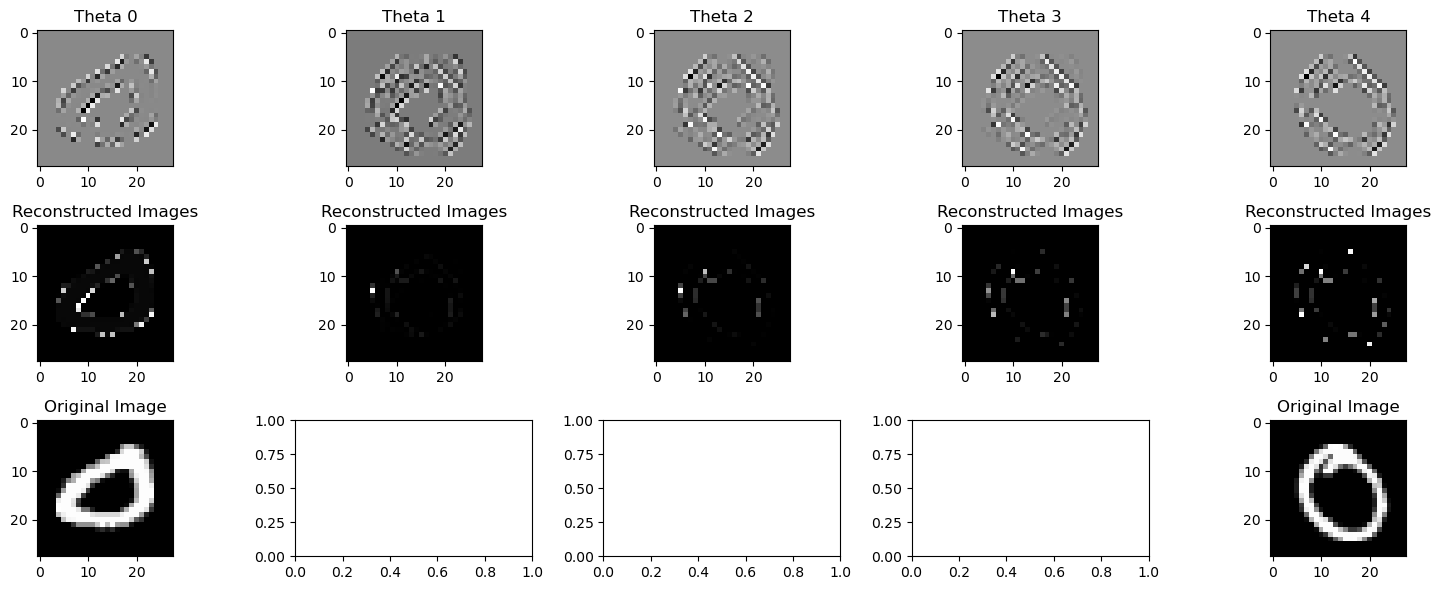

In [5]:
# Pick two random images's theta, and then linear interpolate and plot their images
theta_start, theta_end = thetas[0], thetas[1]

delta_theta = theta_end - theta_start
Q = compute_Q(theta_start)

# Backward-projection
# ld = LegendreDecomposition(solver='ng', max_iter=10, core_size=core_size)
# ld.fit(img)
# eta_start = ld._compute_eta(img)
# eta_end = ld._compute_eta(Q)
# delta_eta = eta_end - eta_start

# Optionally visualize some of the original and sampled thetas
fig, axes = plt.subplots(3, 5, figsize=(15, 6))

for i in range(5):
    theta = theta_start + delta_theta * i / 4
    Q = compute_Q(theta)
    axes[0, i].imshow(theta.reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f'Theta {i}')

    axes[1, i].imshow(Q, cmap='gray')
    axes[1, i].set_title('Reconstructed Images')

    if i == 0:
        axes[2, i].imshow(img_0, cmap='gray')
        axes[2, i].set_title('Original Image')
    elif i == 4:
        axes[2, i].imshow(img_1, cmap='gray')
        axes[2, i].set_title('Original Image')

    # eta = ld._compute_eta(Q) + delta_eta

    # axes[2, i].imshow(Q, cmap='gray')
    # axes[2, i].set_title('Backward-Projected Images')

plt.tight_layout()
plt.show()

# Fitting, Sample, and Backward Projection

In [6]:
from sklearn.neighbors import KernelDensity

# Fit a KDE to the theta values
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(thetas.reshape(20, -1))

# Sample new data from the KDE
num_new_samples = 5
sampled_thetas = kde.sample(n_samples=num_new_samples)

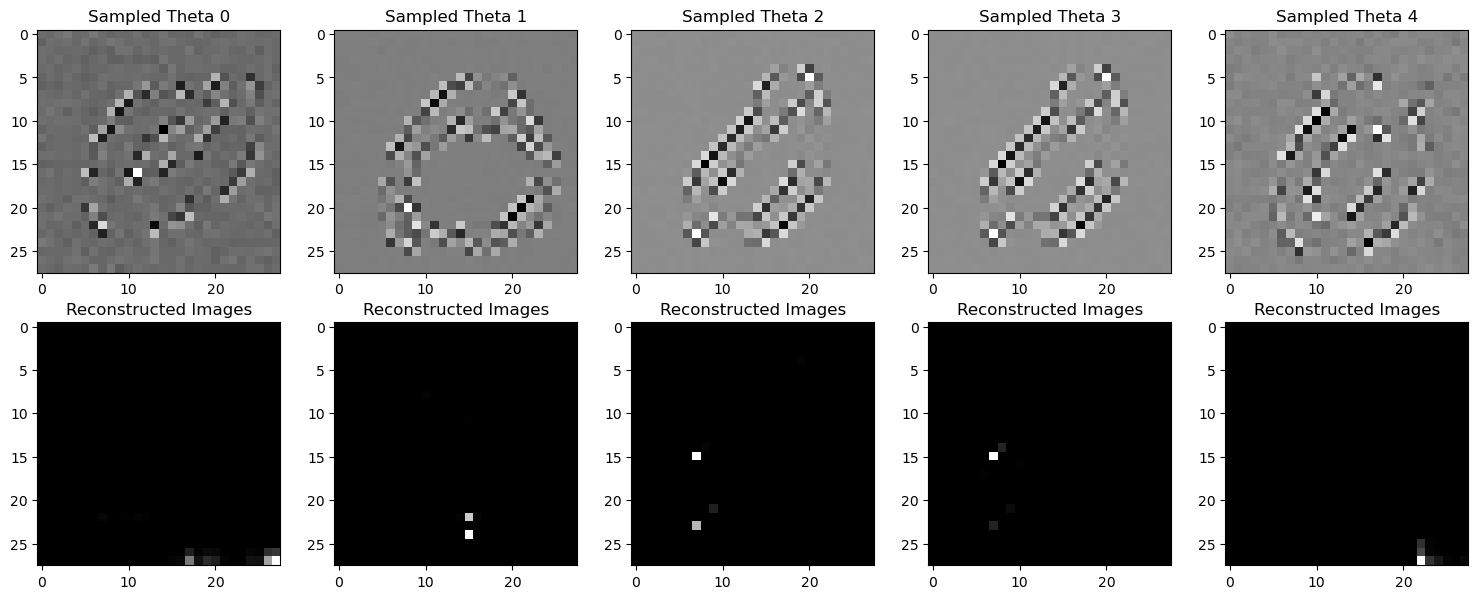

In [7]:
# Reshape sampled thetas to 28x28 for visualization
sampled_thetas = sampled_thetas.reshape(-1, 28, 28)

# Optionally visualize some of the original and sampled thetas
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    Q = compute_Q(sampled_thetas[i])
    axes[0, i].imshow(sampled_thetas[i], cmap='gray')
    axes[0, i].set_title(f'Sampled Theta {i}')

    axes[1, i].imshow(Q, cmap='gray')
    axes[1, i].set_title('Reconstructed Images')

plt.tight_layout()
plt.show()